# Importing Libraries

In [1]:
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm

from keras.applications.vgg16 import VGG16

# Defining the train,test and model directories

* We will create the directories for train,test and model training paths if not present

In [2]:
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","vgg16")
PICKLE_PATH = os.path.join(os.getcwd(),"pickle")
TEST_CSV = os.path.join(os.getcwd(),"csv_files","test.csv")
TRAIN_CSV = os.path.join(os.getcwd(),"csv_files","train.csv")

In [3]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)

In [4]:
data_train = pd.read_csv(TRAIN_CSV)
data_test = pd.read_csv(TEST_CSV)

In [5]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

labels = to_categorical(data_train['ClassName'])
print(labels.shape)

with open(os.path.join(PICKLE_PATH,"labels_list_vgg16.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

{'c8': 0, 'c1': 1, 'c3': 2, 'c7': 3, 'c0': 4, 'c5': 5, 'c6': 6, 'c9': 7, 'c4': 8, 'c2': 9}
(22424, 10)


# Data Preparation

1. Converting the all the train and test images into image size of 64,64,3 
2. Standardizing the flattened image vector 

In [6]:
xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [7]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████| 4485/4485 [00:24<00:00, 186.20it/s]


# MODEL ARCHITECTURE

## Approach Used
1. Removing the top layer of VGG16 model
2. Using the n-1 layers of VGG16 to predict the last layer of it using the flattened image vector 
3. The last layer thus achieved is a dense feature representation for a particular image
4. Passing this layer feature through a GlobalAveragePooling Layer and a further dense softmax layer for each of 10 classes

## Benefits

1. Making CNN architecture from scratch involves in training of all the deep layers which results in slow training
2. Instead of a large sparse image vector a dense feature representation used here requires less memory while training

In [8]:
model = VGG16(include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [9]:
train_vgg16 = model.predict(train_tensors,verbose=1)
valid_vgg16 = model.predict(valid_tensors,verbose=1)

141/141 [==============================] - 189s 1s/step


In [10]:
print("Train shape",train_vgg16.shape)
print("Validation shape",valid_vgg16.shape)

Train shape (17939, 2, 2, 512)
Validation shape (4485, 2, 2, 512)


In [11]:
train_features = train_vgg16[0]
valid_features = valid_vgg16[0]

In [12]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 512)
Validation features shape (2, 2, 512)


In [13]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


In [14]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
plot_model(VGG16_model,to_file=os.path.join(os.getcwd(),"model","vgg16","model_distracted_driver_vgg16.png"),show_shapes=True,show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [16]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [17]:
model_history = VGG16_model.fit(train_vgg16,ytrain,validation_data = (valid_vgg16, ytest),epochs=400, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/400
1122/1122 [==============================] - 4s 3ms/step - loss: 2.0020 - accuracy: 0.3362 - val_loss: 1.4217 - val_accuracy: 0.6069

Epoch 00001: val_accuracy improved from -inf to 0.60691, saving model to /home/abhinav/distracted_driver/model/vgg16/distracted-01-0.61.hdf5
Epoch 2/400
1122/1122 [==============================] - 4s 4ms/step - loss: 1.3281 - accuracy: 0.6395 - val_loss: 1.1269 - val_accuracy: 0.7061

Epoch 00002: val_accuracy improved from 0.60691 to 0.70613, saving model to /home/abhinav/distracted_driver/model/vgg16/distracted-02-0.71.hdf5
Epoch 3/400
1122/1122 [==============================] - 4s 3ms/step - loss: 1.0683 - accuracy: 0.7171 - val_loss: 0.9738 - val_accuracy: 0.7307

Epoch 00003: val_accuracy improved from 0.70613 to 0.73066, saving model to /home/abhinav/distracted_driver/model/vgg16/distracted-03-0.73.hdf5
Epoch 4/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.9263 - accuracy: 0.7505 - val_loss: 0.8501 - val_accur

1122/1122 [==============================] - 2s 1ms/step - loss: 0.3269 - accuracy: 0.9114 - val_loss: 0.3546 - val_accuracy: 0.8981

Epoch 00033: val_accuracy improved from 0.89588 to 0.89810, saving model to /home/abhinav/distracted_driver/model/vgg16/distracted-33-0.90.hdf5
Epoch 34/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.3191 - accuracy: 0.9124 - val_loss: 0.3580 - val_accuracy: 0.8988

Epoch 00034: val_accuracy improved from 0.89810 to 0.89877, saving model to /home/abhinav/distracted_driver/model/vgg16/distracted-34-0.90.hdf5
Epoch 35/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.3182 - accuracy: 0.9116 - val_loss: 0.3534 - val_accuracy: 0.9012

Epoch 00035: val_accuracy improved from 0.89877 to 0.90123, saving model to /home/abhinav/distracted_driver/model/vgg16/distracted-35-0.90.hdf5
Epoch 36/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.3113 - accuracy: 0.9173 - val_loss: 0.3499 - val_accuracy: 0

1122/1122 [==============================] - 2s 2ms/step - loss: 0.2142 - accuracy: 0.9381 - val_loss: 0.2814 - val_accuracy: 0.9166

Epoch 00105: val_accuracy did not improve from 0.91996
Epoch 106/400
1122/1122 [==============================] - 2s 2ms/step - loss: 0.2067 - accuracy: 0.9425 - val_loss: 0.2735 - val_accuracy: 0.9186

Epoch 00106: val_accuracy did not improve from 0.91996
Epoch 107/400
1122/1122 [==============================] - 2s 2ms/step - loss: 0.2112 - accuracy: 0.9390 - val_loss: 0.2724 - val_accuracy: 0.9213

Epoch 00107: val_accuracy improved from 0.91996 to 0.92129, saving model to /home/abhinav/distracted_driver/model/vgg16/distracted-107-0.92.hdf5
Epoch 108/400
1122/1122 [==============================] - 2s 2ms/step - loss: 0.2140 - accuracy: 0.9408 - val_loss: 0.2753 - val_accuracy: 0.9175

Epoch 00108: val_accuracy did not improve from 0.92129
Epoch 109/400
1122/1122 [==============================] - 2s 2ms/step - loss: 0.2159 - accuracy: 0.9381 - val_l


Epoch 00144: val_accuracy did not improve from 0.92219
Epoch 145/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1950 - accuracy: 0.9457 - val_loss: 0.2667 - val_accuracy: 0.9202

Epoch 00145: val_accuracy did not improve from 0.92219
Epoch 146/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.2061 - accuracy: 0.9418 - val_loss: 0.2673 - val_accuracy: 0.9179

Epoch 00146: val_accuracy did not improve from 0.92219
Epoch 147/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.2007 - accuracy: 0.9440 - val_loss: 0.2690 - val_accuracy: 0.9182

Epoch 00147: val_accuracy did not improve from 0.92219
Epoch 148/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1964 - accuracy: 0.9461 - val_loss: 0.2708 - val_accuracy: 0.9202

Epoch 00148: val_accuracy did not improve from 0.92219
Epoch 149/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1981 - accuracy: 0.9463 - val_loss: 0.2697 - val_ac


Epoch 00184: val_accuracy did not improve from 0.92308
Epoch 185/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1991 - accuracy: 0.9452 - val_loss: 0.2633 - val_accuracy: 0.9233

Epoch 00185: val_accuracy improved from 0.92308 to 0.92330, saving model to /home/abhinav/distracted_driver/model/vgg16/distracted-185-0.92.hdf5
Epoch 186/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1920 - accuracy: 0.9477 - val_loss: 0.2671 - val_accuracy: 0.9202

Epoch 00186: val_accuracy did not improve from 0.92330
Epoch 187/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1927 - accuracy: 0.9473 - val_loss: 0.2662 - val_accuracy: 0.9206

Epoch 00187: val_accuracy did not improve from 0.92330
Epoch 188/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1935 - accuracy: 0.9473 - val_loss: 0.2699 - val_accuracy: 0.9186

Epoch 00188: val_accuracy did not improve from 0.92330
Epoch 189/400
1122/1122 [=================


Epoch 00224: val_accuracy did not improve from 0.92330
Epoch 225/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1916 - accuracy: 0.9476 - val_loss: 0.2699 - val_accuracy: 0.9166

Epoch 00225: val_accuracy did not improve from 0.92330
Epoch 226/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1819 - accuracy: 0.9486 - val_loss: 0.2683 - val_accuracy: 0.9208

Epoch 00226: val_accuracy did not improve from 0.92330
Epoch 227/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1869 - accuracy: 0.9487 - val_loss: 0.2738 - val_accuracy: 0.9179

Epoch 00227: val_accuracy did not improve from 0.92330
Epoch 228/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1815 - accuracy: 0.9492 - val_loss: 0.2703 - val_accuracy: 0.9217

Epoch 00228: val_accuracy did not improve from 0.92330
Epoch 229/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1882 - accuracy: 0.9499 - val_loss: 0.2773 - val_ac

1122/1122 [==============================] - 1s 1ms/step - loss: 0.1763 - accuracy: 0.9495 - val_loss: 0.2869 - val_accuracy: 0.9164

Epoch 00305: val_accuracy did not improve from 0.92330
Epoch 306/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1769 - accuracy: 0.9507 - val_loss: 0.2813 - val_accuracy: 0.9164

Epoch 00306: val_accuracy did not improve from 0.92330
Epoch 307/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1692 - accuracy: 0.9536 - val_loss: 0.2786 - val_accuracy: 0.9197

Epoch 00307: val_accuracy did not improve from 0.92330
Epoch 308/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1725 - accuracy: 0.9535 - val_loss: 0.2835 - val_accuracy: 0.9162

Epoch 00308: val_accuracy did not improve from 0.92330
Epoch 309/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1718 - accuracy: 0.9554 - val_loss: 0.2813 - val_accuracy: 0.9188

Epoch 00309: val_accuracy did not improve from 0.92330

1122/1122 [==============================] - 2s 2ms/step - loss: 0.1654 - accuracy: 0.9537 - val_loss: 0.2997 - val_accuracy: 0.9148

Epoch 00385: val_accuracy did not improve from 0.92330
Epoch 386/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1752 - accuracy: 0.9506 - val_loss: 0.2970 - val_accuracy: 0.9153

Epoch 00386: val_accuracy did not improve from 0.92330
Epoch 387/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1792 - accuracy: 0.9506 - val_loss: 0.2969 - val_accuracy: 0.9151

Epoch 00387: val_accuracy did not improve from 0.92330
Epoch 388/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1734 - accuracy: 0.9546 - val_loss: 0.2936 - val_accuracy: 0.9204

Epoch 00388: val_accuracy did not improve from 0.92330
Epoch 389/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1703 - accuracy: 0.9530 - val_loss: 0.2947 - val_accuracy: 0.9155

Epoch 00389: val_accuracy did not improve from 0.92330

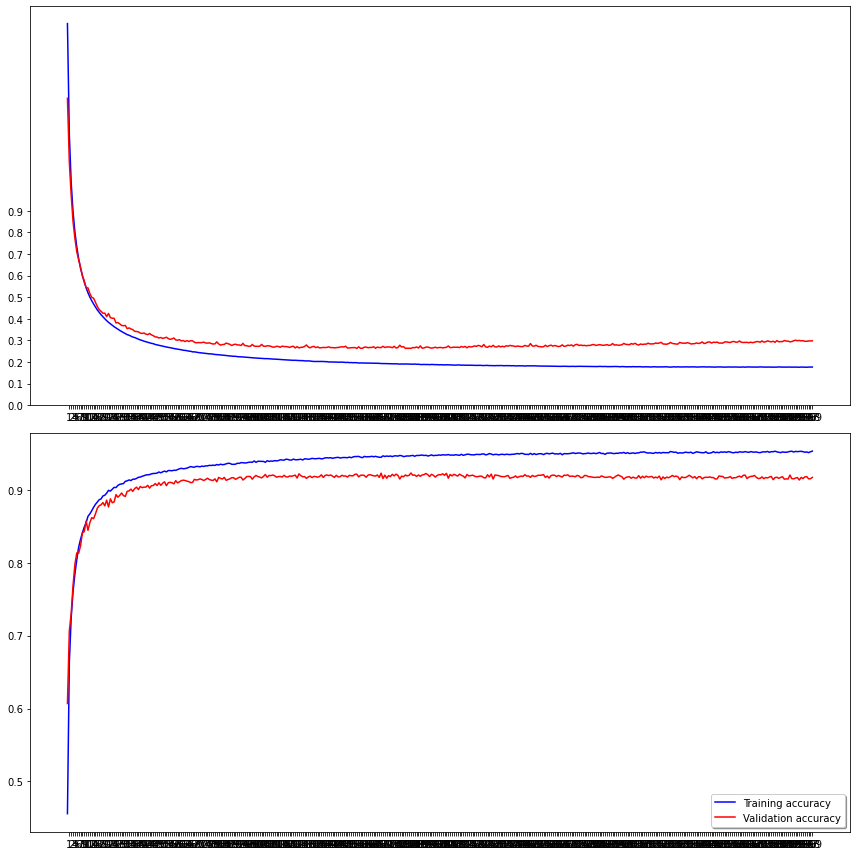

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 400, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 400, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [20]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [21]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = VGG16_model.predict(valid_vgg16,verbose=1)

141/141 [==============================] - 0s 941us/step


## Confusion Matrix

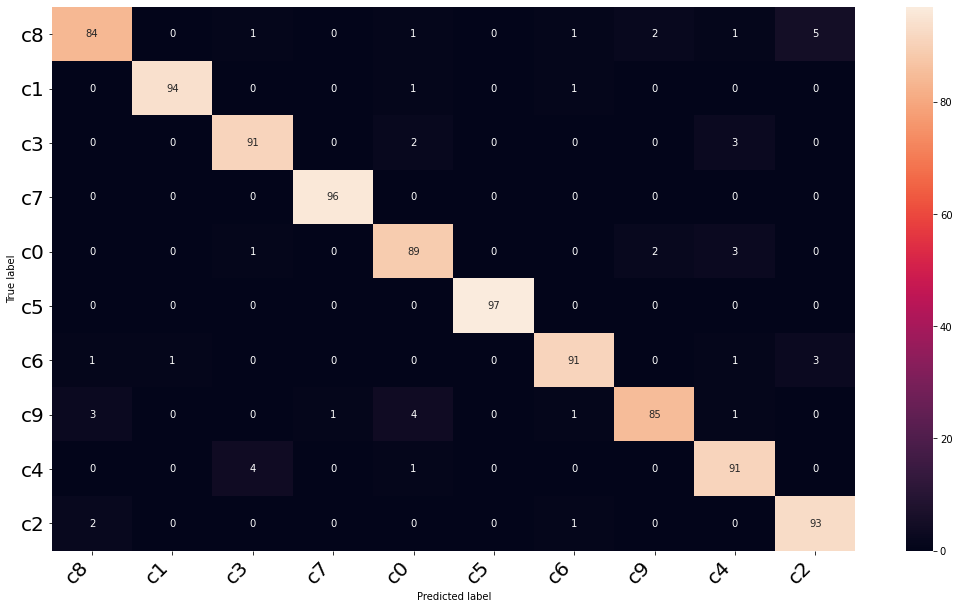

In [22]:
print_heatmap(ytest,ypred,class_names)

# Precision Recall F1 Score

In [23]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [24]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.917280
Precision: 0.917375
Recall: 0.917280
F1 score: 0.917142
